## Overview: comparing feature approaches
This notebook demonstrates how simple, interpretable features can be used to classify facial expressions using the local dataset in `Data/train/`.

Goals:
- Compute two kinds of hand-crafted features (Intensity and LBP) for each image.
- Train identical classifiers on each feature set and compare their performance using the same train/test split for fairness.
- Visualize example images, intensity histograms, and LBP maps to build intuition about why features work (or fail).

Features we extract:
- Intensity features: mean intensity, standard deviation, and a 256-bin normalized intensity histogram. These capture global brightness/contrast and are fast to compute.
- LBP (Local Binary Patterns): uniform patterns computed over a resized grayscale face. LBP summarizes local texture and micro-patterns (wrinkles, creases).
- Combined: concatenation of intensity and LBP produces a single vector that includes both global and local cues.

Why these choices?
- Intensity can capture changes caused by visible teeth, open mouth, or overall lighting differences between expressions.
- LBP captures local texture changes around eyes and mouth that often correlate with expressions (e.g., crow's feet for smiling, creases for frowning).
- Combining them often gives complementary information and sometimes improves separability.

Workflow (quick): helpers → compute features → build datasets → train models → compare results and inspect confusion matrices.

How to read later outputs:
- Accuracy bars: compare feature sets (intensity, LBP, combined) across models (SVM, LogReg). Higher bars = better test accuracy.
- Model comparison: we train and compare two classifiers: SVM (RBF kernel) and Logistic Regression (multinomial).
  - SVM: a margin-based classifier that can capture non-linear boundaries with an RBF kernel; often works well with medium-dimensional, well-scaled features.
  - Logistic Regression: a linear, probabilistic classifier that is fast and easier to interpret; with `multi_class='multinomial'` it models class probabilities directly.
  - Expect SVM to sometimes outperform LogReg on non-linearly separable data, while LogReg is more stable and faster on large datasets.
- Confusion matrices: rows=true labels, columns=predicted labels — check diagonals for correct counts and off-diagonals for common confusions.
- Intensity histograms and LBP maps: use these to reason about why a feature separates or confuses certain classes.

### Why these features can work for facial emotion recognition
A concise rationale and practical notes for each feature type:

1) Intensity-based features:
- Mean intensity: captures global brightness differences (e.g., open mouth with visible teeth can raise the mean).
- Standard deviation: measures contrast/variability — large values can indicate strong shadowing or open-mouth expressions.
- Intensity histogram: summarizes the full brightness distribution; useful when expressions systematically shift that distribution (more bright pixels when teeth are visible, more dark pixels when faces are shadowed).

2) LBP (Local Binary Patterns):
- Encodes local texture patterns around each pixel (uniform patterns chosen here).
- LBP is robust to monotonic illumination changes and captures micro-structure (wrinkles, creases) that often change with expression.
- We use uniform LBP and fix the histogram length to P + 2 so all feature vectors align across images.

3) Combined features:
- Concatenating intensity and LBP gives both global and local information and often improves separability for certain classes.

Limitations and caveats:
- Hand-crafted features are interpretable but usually lag behind modern CNNs on large, varied datasets.
- Lighting, occlusion (glasses, hands), and head pose reduce feature usefulness; consider simple pre-processing (cropping/alignment, histogram equalization) if needed.

How to interpret diagnostics (practical):
- If two classes have nearly identical intensity histograms, intensity-only models will struggle — check LBP or combined results.
- Use the confusion matrix to identify which classes are confused; per-class F1 in the classification report helps prioritize improvements.

## Visual examples: image, intensity histogram, and LBP map
Below we display example images for each label with two diagnostics. These visuals explain the intuition behind intensity and LBP features.

What each column shows:
- Left — grayscale image (48×48): inspect mouth openness, teeth visibility, and shadowing. These affect mean and histogram shape.
- Middle — intensity histogram (density): shows how pixel brightness values are distributed. Example: a strong peak near the high end often corresponds to bright pixels (teeth/highlights).
- Right — LBP map: a visualization of local binary patterns (texture). Look for increased texture around eyes/mouth when expressions cause wrinkles/creases.

How these help:
- If a label shows consistently brighter histograms (e.g., smiling with visible teeth), intensity features will likely separate that label from darker expressions.
- If two labels have similar histograms, but different local texture patterns in the LBP maps, LBP features can provide the discriminative signal.

Quick options:
- Increase `N_EXAMPLES_PER_LABEL` to see more samples per label.
- Tweak `HIST_BINS` to smooth or sharpen histogram detail.
- If images look misaligned, consider adding a light pre-processing step (crop/align/normalize) before feature extraction.

In [1]:
# Common helpers: dataset paths, file listing, image loading, dataset builder
from pathlib import Path
from PIL import Image
import numpy as np

ROOT = Path('.')  # notebook root
DATA_TRAIN = ROOT / 'Data' / 'train'
EXTS = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
DEFAULT_LABELS = ['angry','disgust','fear','happy','neutral','sad','surprise']
DEFAULT_N_PER_LABEL = 100

def get_labels():
    return DEFAULT_LABELS

def list_image_files(label, exts=EXTS, n=None):
    data_dir = DATA_TRAIN / label
    if not data_dir.exists():
        return []
    files = []
    for e in exts:
        files.extend(sorted(data_dir.glob(e)))
    return sorted(files)[:n] if n is not None else sorted(files)

def load_image_as_gray(p, size=None, dtype='float32', scale01=False):
    with Image.open(p) as im:
        im = im.convert('L')
        if size and im.size != size:
            im = im.resize(size)
        arr = np.array(im, dtype=dtype)
        if scale01:
            return arr.astype('float32') / 255.0
        return arr

def build_feature_dataset(feature_fn, labels=None, n_per_label=DEFAULT_N_PER_LABEL, size=None, as_uint8=False):
    labels = labels or get_labels()
    X = []
    y = []
    for lbl in labels:
        files = list_image_files(lbl, n=n_per_label)
        for p in files:
            try:
                arr = load_image_as_gray(p, size=size, dtype='uint8' if as_uint8 else 'float32', scale01=False)
                if as_uint8:
                    arr = arr.astype('uint8')
                feat = feature_fn(arr)
                X.append(feat)
                y.append(lbl)
            except Exception as e:
                print('skip', p, e)
    return (np.vstack(X) if len(X)>0 else np.empty((0,))), np.array(y)


In [2]:
# Feature extractor helpers (intensity and LBP)
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

# Intensity features: mean, std, 256-bin normalized histogram
def extract_intensity_features_from_array(arr):
    arr_u8 = arr.astype('uint8')
    mean_intensity = np.mean(arr_u8)
    std_intensity = np.std(arr_u8)
    hist = cv2.calcHist([arr_u8], [0], None, [256], [0, 256]).flatten()
    s = hist.sum()
    if s > 0:
        hist = hist / s
    features = np.concatenate(([mean_intensity, std_intensity], hist))
    return features

# LBP features: uniform LBP with fixed bins (P + 2)
RADIUS = 1
N_POINTS = 8 * RADIUS
METHOD = 'uniform'
N_BINS = N_POINTS + 2

def extract_lbp_features(img, n_bins=N_BINS):
    # img expected uint8 grayscale 2D array
    lbp = local_binary_pattern(img, N_POINTS, RADIUS, METHOD)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist

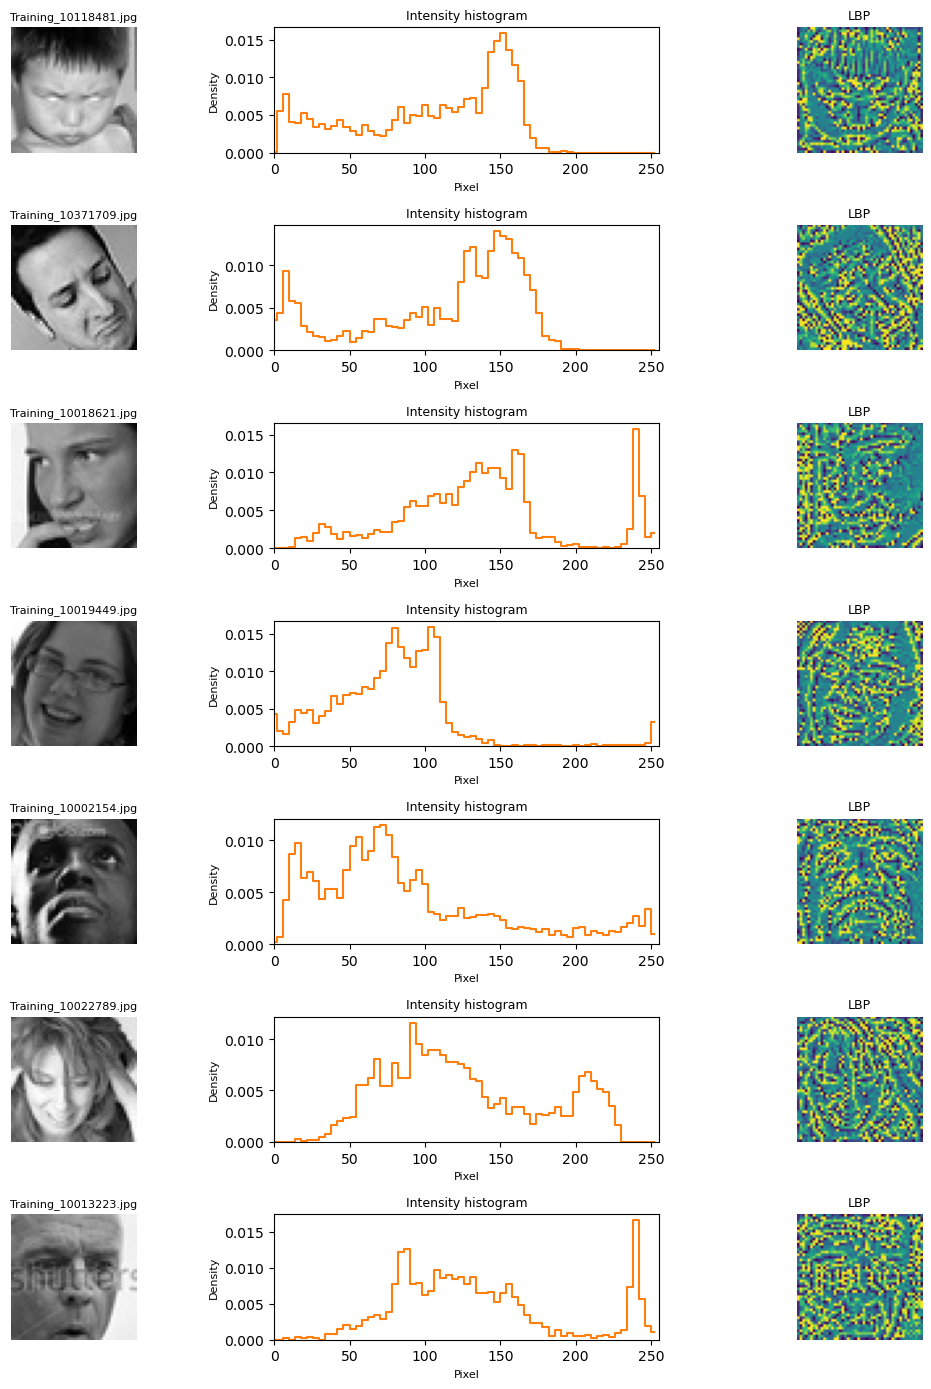

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import local_binary_pattern

# Show multiple examples per label (robust to matplotlib axis shapes)
# Use fewer bins for visibility and step plotting to avoid crowded lines
N_EXAMPLES_PER_LABEL = 1
HIST_BINS = 64  # fewer bins for clarity
labels = get_labels()
cols = 3 * N_EXAMPLES_PER_LABEL
# Wider figure so histograms have room; height scales with number of labels
fig, axes = plt.subplots(len(labels), cols, figsize=(12, 2 * max(1, len(labels))))
# Add spacing between subplots to avoid crowding
fig.subplots_adjust(hspace=0.5, wspace=0.35)
axes = np.asarray(axes)
# ensure axes is 2D with shape (n_labels, cols)
if axes.ndim == 1:
    axes = axes.reshape((len(labels), cols))
for i, lbl in enumerate(labels):
    files = list_image_files(lbl, n=DEFAULT_N_PER_LABEL)
    examples = files[:N_EXAMPLES_PER_LABEL] if files else []
    for j in range(N_EXAMPLES_PER_LABEL):
        col_base = j * 3
        ax_img = axes[i, col_base]
        ax_hist = axes[i, col_base + 1]
        ax_lbp = axes[i, col_base + 2]
        if j < len(examples):
            p = examples[j]
            img = load_image_as_gray(p, size=(48,48), dtype='uint8')
            ax_img.imshow(img, cmap='gray')
            ax_img.axis('off')
            if j == 0:
                ax_img.set_ylabel(lbl, fontsize=10)
            ax_img.set_title(p.name, fontsize=8)
            hist, bins = np.histogram(img.ravel(), bins=HIST_BINS, range=(0,256), density=True)
            # Use a step plot which is easier to read when there are many values
            ax_hist.step(bins[:-1], hist, where='mid', color='C1')
            ax_hist.set_xlim(0,255)
            ax_hist.set_ylim(0, max(hist.max()*1.05, 0.001))
            ax_hist.set_title('Intensity histogram', fontsize=9)
            ax_hist.set_xlabel('Pixel', fontsize=8)
            ax_hist.set_ylabel('Density', fontsize=8)
            lbp_map = local_binary_pattern(img, 8, 1, 'uniform')
            ax_lbp.imshow(lbp_map, cmap='viridis')
            ax_lbp.axis('off')
            ax_lbp.set_title('LBP', fontsize=9)
        else:
            ax_img.axis('off')
            ax_hist.axis('off')
            ax_lbp.axis('off')
plt.tight_layout()
plt.show()

### Comparison: Intensity vs LBP vs Combined — details and interpretation
This cell builds three datasets (intensity, LBP, combined) using the helper functions, trains identical models on each, and prints/plots results so you can decide which feature set helps most.

Exact outputs the cell produces:
- For each model-feature pair the cell prints an accuracy and a classification report (precision, recall, F1 for each class).
- A grouped bar chart showing test accuracies for each feature method (intensity, LBP, combined) grouped by model (SVM, LogReg).
- Confusion matrices (heatmaps) for each model showing where the classifier confuses classes.

Interpretation checklist:
- Compare bars across feature methods first — higher bars generally mean the method provides stronger discriminative signal for that classifier.
- Model-level differences to look for:
  - SVM (RBF): non-linear decision boundaries — may achieve higher accuracy when classes separate non-linearly. It can be slower to train but often performs well with medium-sized feature vectors.
  - Logistic Regression: linear, probabilistic model — faster and more stable on high-dimensional or sparse features; easier to interpret class logits and probabilities.
  - If SVM beats LogReg consistently for a given feature set, that suggests the feature space benefits from non-linear separation. If LogReg is competitive, the features may already be (near) linearly separable.
- Use per-class F1 from the classification report to find classes that need more data or different features.
- Inspect confusion matrices to detect systematic confusions (e.g., 'sad' ↔ 'neutral').

Reproducibility and practical notes:
- The code reuses a single train/test index split for all feature sets so comparisons are fair across methods.
- If some classes have very few samples, stratified splitting may be disabled and the cell will print a warning; in that case, consider increasing `DEFAULT_N_PER_LABEL` or running k-fold CV.
- For final evaluation use cross-validation and multiple random seeds; this notebook focuses on quick, interpretable comparisons.

If you get errors: run the helper cells (image loading and feature extractors) first, then this comparison cell. If stratify fails, run the diagnostic cell to inspect label counts.

/Users/xinyizhu/anaconda3/envs/w207/lib/python3.10/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Shapes: intensity (700, 258) lbp (700, 10) combined (700, 268) y (700,)
--- intensity + SVM ---
Accuracy: 0.15
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        20
     disgust       0.00      0.00      0.00        20
        fear       0.20      0.05      0.08        20
       happy       0.13      0.20      0.16        20
     neutral       0.17      0.15      0.16        20
         sad       0.21      0.25      0.23        20
    surprise       0.23      0.40      0.29        20

    accuracy                           0.15       140
   macro avg       0.13      0.15      0.13       140
weighted avg       0.13      0.15      0.13       140

--- lbp + SVM ---
Accuracy: 0.18571428571428572
              precision    recall  f1-score   support

       angry       0.24      0.25      0.24        20
     disgust       0.17      0.25      0.20        20
        fear       0.00      0.00      0.00        20
       happy       0.25    

/Users/xinyizhu/anaconda3/envs/w207/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- intensity + LogReg ---
Accuracy: 0.12857142857142856
              precision    recall  f1-score   support

       angry       0.15      0.20      0.17        20
     disgust       0.14      0.15      0.14        20
        fear       0.16      0.15      0.15        20
       happy       0.05      0.05      0.05        20
     neutral       0.14      0.10      0.12        20
         sad       0.16      0.20      0.18        20
    surprise       0.08      0.05      0.06        20

    accuracy                           0.13       140
   macro avg       0.13      0.13      0.12       140
weighted avg       0.13      0.13      0.12       140

--- lbp + LogReg ---
Accuracy: 0.15714285714285714
              precision    recall  f1-score   support

       angry       0.14      0.05      0.07        20
     disgust       0.06      0.05      0.05        20
        fear       0.25      0.15      0.19        20
       happy       0.12      0.20      0.15        20
     neutral       0.18 

/Users/xinyizhu/anaconda3/envs/w207/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/xinyizhu/anaconda3/envs/w207/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


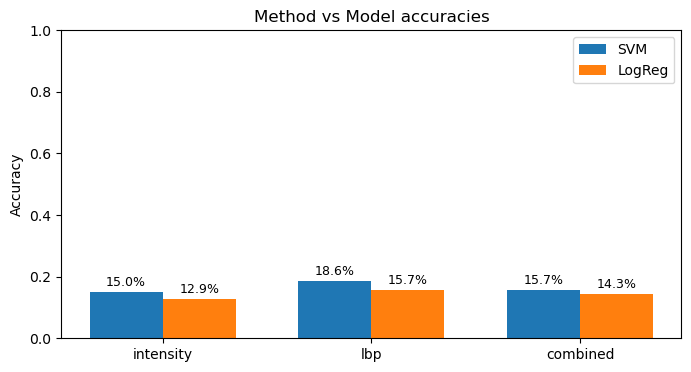

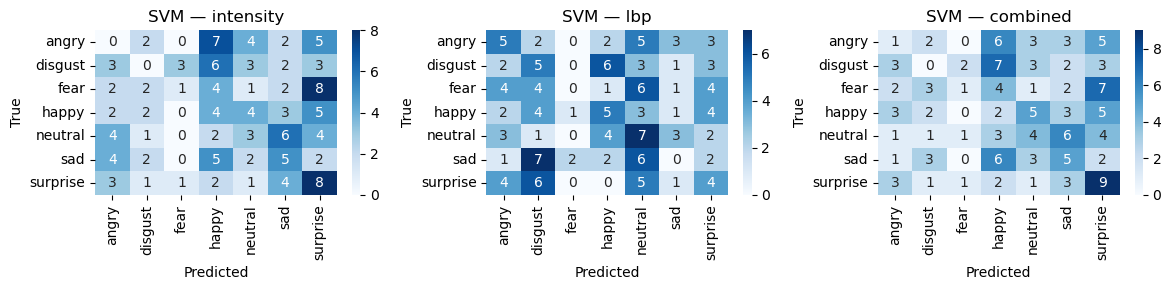

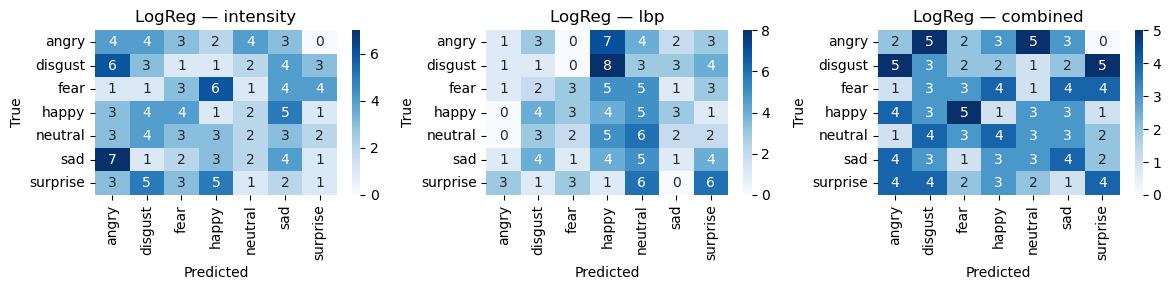

In [4]:
# Compare three feature extraction methods: Intensity, LBP, and Combined (SVM + LogisticRegression)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import traceback

try:
    # Reuse parameters and helpers from previous cells (assumes they ran)
    ROOT = Path('.')
    DATA_TRAIN = ROOT / 'Data' / 'train'
    labels = get_labels()
    N_PER_LABEL = DEFAULT_N_PER_LABEL

    # Build datasets for each feature type using helpers (these functions defined above)
    intensity_X, y_int = build_feature_dataset(extract_intensity_features_from_array, labels=labels, n_per_label=N_PER_LABEL, size=(48,48), as_uint8=True)
    lbp_X, y_lbp = build_feature_dataset(extract_lbp_features, labels=labels, n_per_label=N_PER_LABEL, size=(48,48), as_uint8=False)

    # Ensure labels match
    if not (len(y_int) == len(y_lbp) and all(y_int == y_lbp)):
        # fallback: use y_int as canonical labels if shapes differ
        y = y_int if len(y_int) > 0 else y_lbp
    else:
        y = y_int

    if len(y) == 0:
        print('No labels found. Ensure Data/train/* contains images and rerun helpers.')
        raise SystemExit

    # Convert to 2D arrays if needed (they should already be 2D from the helper)
    intensity_X = np.vstack(intensity_X) if (hasattr(intensity_X, 'ndim') and intensity_X.size != 0 and intensity_X.ndim > 1) else intensity_X
    lbp_X = np.vstack(lbp_X) if (hasattr(lbp_X, 'ndim') and lbp_X.size != 0 and lbp_X.ndim > 1) else lbp_X

    # Combined features
    if (isinstance(intensity_X, np.ndarray) and isinstance(lbp_X, np.ndarray) and intensity_X.size and lbp_X.size):
        combined_X = np.hstack([intensity_X, lbp_X])
    else:
        combined_X = intensity_X if (isinstance(intensity_X, np.ndarray) and intensity_X.size) else lbp_X

    print('Shapes: intensity', getattr(intensity_X, 'shape', None), 'lbp', getattr(lbp_X, 'shape', None), 'combined', getattr(combined_X, 'shape', None), 'y', y.shape)

    # Create a reproducible train/test index split once and reuse for fair comparison
    from collections import Counter
    label_counts = Counter(y)
    use_stratify = all(v >= 2 for v in label_counts.values()) and len(label_counts) > 1
    stratify_arg = y if use_stratify else None
    if not use_stratify:
        print('Stratify disabled due to small class counts:', label_counts)

    indices = np.arange(len(y))
    # Split indices directly; stratify accepts the y array
    idx_train, idx_test = train_test_split(indices, test_size=0.2, random_state=42, stratify=stratify_arg)
    y_train = y[idx_train]
    y_test = y[idx_test]

    # Train and evaluate function for a model on given X
    def fit_and_eval_model(X, model, name):
        if not (isinstance(X, np.ndarray) and X.size):
            raise ValueError(f'Feature matrix for {name} is empty or not an ndarray')
        if X.shape[0] != len(y):
            raise ValueError(f'Feature matrix row count ({X.shape[0]}) does not match number of labels ({len(y)}) for {name}')
        X_train = X[idx_train]
        X_test = X[idx_test]
        pipe = make_pipeline(StandardScaler(), model)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f'--- {name} ---')
        print('Accuracy:', acc)
        print(classification_report(y_test, y_pred))
        return acc, y_test, y_pred

    methods = ['intensity', 'lbp', 'combined']
    features = {'intensity': intensity_X, 'lbp': lbp_X, 'combined': combined_X}
    models = {'SVM': SVC(kernel='rbf', C=1.0, gamma='scale'), 'LogReg': LogisticRegression(max_iter=1000, multi_class='multinomial')}

    results = {m: {} for m in models}
    conf_matrices = {m: {} for m in models}

    for mname, mobj in models.items():
        for fname in methods:
            X = features[fname]
            if not (isinstance(X, np.ndarray) and X.size):
                print(f'Skipping {fname} for {mname} (no data)')
                continue
            acc, y_true, y_pred = fit_and_eval_model(X, mobj, f'{fname} + {mname}')
            results[mname][fname] = acc
            conf_matrices[mname][fname] = confusion_matrix(y_true, y_pred, labels=labels)

    # Plot grouped bar chart for accuracies
    fig, ax = plt.subplots(figsize=(8,4))
    x = np.arange(len(methods))
    width = 0.35
    for i, (mname, res) in enumerate(results.items()):
        accs = [res.get(f, 0.0) for f in methods]
        ax.bar(x + (i-0.5)*width, accs, width, label=mname)
        for xi, v in enumerate(accs):
            ax.text(xi + (i-0.5)*width, v + 0.01, f'{v*100:.1f}%', ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.set_ylim(0,1)
    ax.set_ylabel('Accuracy')
    ax.set_title('Method vs Model accuracies')
    ax.legend()
    plt.show()

    # Display confusion matrices for each model-method pair in a grid
    for mname in models:
        fig, axes = plt.subplots(1, len(methods), figsize=(4*len(methods), 3))
        for i, fname in enumerate(methods):
            cm = conf_matrices[mname].get(fname)
            ax = axes[i]
            if cm is None:
                ax.axis('off')
                continue
            sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues', ax=ax)
            ax.set_title(f'{mname} — {fname}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
        plt.tight_layout()
        plt.show()

except Exception:
    print('An error occurred while running the comparison cell:')
    traceback.print_exc()
    raise
